### 1. ChatGPT 감성점수 VS FinBERT, VADER, TEXTBLOB 모델 성능 비교

--- 1. FinBERT 모델 로딩 중... (시간이 소요될 수 있습니다) ---
   -> 사용 장치: GPU


Device set to use cuda:0


   -> FinBERT 로드 완료

--- 2. 데이터 로드 및 전처리 ---
   -> 데이터 로드 완료: 291건

--- 3. 감성 점수 산출 중 (대상 컬럼: content) ---
   -> VADER 완료
   -> TextBlob 완료
   -> FinBERT 계산 시작... (데이터 양에 따라 수 분 소요)
   -> FinBERT 완료

--- 4. 주가 데이터 다운로드 및 CAR 계산 ---


/tmp/ipython-input-3518528084.py:129: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start=start_date.date(), progress=False)


   -> 주가 데이터 다운로드 완료
   -> CAR 계산 완료 (유효 샘플: 233개)

--- 5. 최종 회귀분석 결과 비교 ---
Model           | R-squared  | P-value    | Coef      
-------------------------------------------------------
sentiment       | 0.0169     | 0.0475     | 0.0108
score_vader     | 0.0000     | 0.9637     | 0.0002
score_textblob  | 0.0002     | 0.8343     | -0.0029
score_finbert   | 0.0012     | 0.6060     | 0.0039


/tmp/ipython-input-3518528084.py:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=stats_df, palette='viridis')


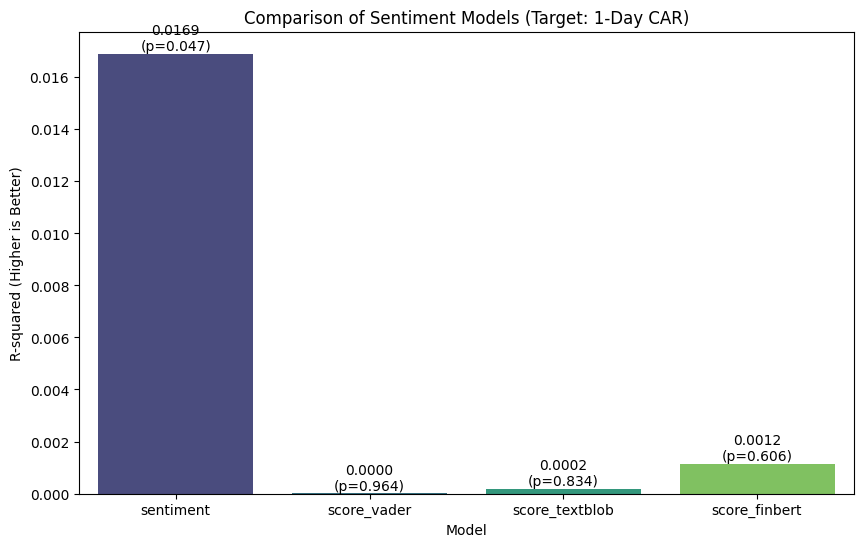

In [ ]:
# ==============================================================================
# 라이브러리 설치
# ==============================================================================

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch

# ------------------------------------------------------------------------------
# 분석할 텍스트 컬럼
# ------------------------------------------------------------------------------
TEXT_COL = 'content'  # 트윗 본문이 있는 컬럼명

# VADER 사전 다운로드 (최초 1회)
nltk.download('vader_lexicon', quiet=True)

# ==============================================================================
# 1. FinBERT 모델 로드 (금융 특화 모델)
# ==============================================================================
print("--- 1. FinBERT 모델 로딩 중... (시간이 소요될 수 있습니다) ---")
# GPU 사용 가능 여부 확인
device = 0 if torch.cuda.is_available() else -1
print(f"   -> 사용 장치: {'GPU' if device == 0 else 'CPU'}")

try:
    tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
    model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
    nlp_finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
    print("   -> FinBERT 로드 완료")
except Exception as e:
    print(f"   -> 오류: FinBERT 로드 실패. ({e})")
    nlp_finbert = None

# ==============================================================================
# 2. 감성 점수 계산 함수 정의
# ==============================================================================
sid = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if pd.isna(text) or text == '': return 0.0
    return sid.polarity_scores(str(text))['compound']

def get_textblob_score(text):
    if pd.isna(text) or text == '': return 0.0
    return TextBlob(str(text)).sentiment.polarity

def get_finbert_score(text):
    if nlp_finbert is None or pd.isna(text) or text == '': return 0.0
    try:
        # 모델 입력 길이 제한(512토큰)에 맞춰 텍스트 자르기
        results = nlp_finbert([str(text)[:512]])[0]
        label = results['label']
        score = results['score']

        # 라벨을 점수로 변환 (Positive: +, Negative: -, Neutral: 0)
        if label.lower() == 'positive': return score
        elif label.lower() == 'negative': return -score
        else: return 0.0
    except:
        return 0.0

# ==============================================================================
# 3. 데이터 로드 및 전처리
# ==============================================================================
print("\n--- 2. 데이터 로드 및 전처리 ---")
try:
    ticker_df = pd.read_csv('ticker_F.csv')
    full_tweet_df = pd.read_csv('Direct_data_all_by_ticker_F.csv')
    print(f"   -> 데이터 로드 완료: {len(full_tweet_df)}건")
except FileNotFoundError:
    print("   -> 오류: 데이터 파일(ticker_F.csv, Direct_data_all_by_ticker_F.csv)이 없습니다.")
    raise

# 날짜 변환 및 시장 지수 설정
full_tweet_df['time'] = pd.to_datetime(full_tweet_df['time'])
full_tweet_df['market_ticker'] = '^GSPC'

# ==============================================================================
# 4. 감성 점수 일괄 계산
# ==============================================================================
print(f"\n--- 3. 감성 점수 산출 중 (대상 컬럼: {TEXT_COL}) ---")

if TEXT_COL in full_tweet_df.columns:
    # 1) VADER
    full_tweet_df['score_vader'] = full_tweet_df[TEXT_COL].apply(get_vader_score)
    print("   -> VADER 완료")

    # 2) TextBlob
    full_tweet_df['score_textblob'] = full_tweet_df[TEXT_COL].apply(get_textblob_score)
    print("   -> TextBlob 완료")

    # 3) FinBERT (오래 걸릴 수 있음)
    if nlp_finbert:
        print("   -> FinBERT 계산 시작... (데이터 양에 따라 수 분 소요)")
        # 진행률 표시를 원하면 tqdm 사용 권장
        full_tweet_df['score_finbert'] = full_tweet_df[TEXT_COL].apply(get_finbert_score)
        print("   -> FinBERT 완료")
    else:
        full_tweet_df['score_finbert'] = 0.0
else:
    print(f"   -> 오류: '{TEXT_COL}' 컬럼을 찾을 수 없어 추가 점수 계산을 건너뜁니다.")

tweet_df = full_tweet_df.copy()

# ==============================================================================
# 5. 주가 데이터 다운로드 및 CAR(0,0) 계산
# ==============================================================================
print("\n--- 4. 주가 데이터 다운로드 및 CAR 계산 ---")
MARKET_CLOSE_HOUR = 16
ESTIMATION_PERIOD_DAYS = 251
EVENT_WINDOW_DAYS = 0  # 하루 모델

# 티커 리스트
all_tickers = list(set(tweet_df['ticker'].unique().tolist() + tweet_df['market_ticker'].unique().tolist()))
start_date = tweet_df['time'].min().normalize() - timedelta(days=ESTIMATION_PERIOD_DAYS * 1.5)

# 다운로드
try:
    all_data = yf.download(all_tickers, start=start_date.date(), progress=False)
    if 'Adj Close' in all_data.columns.get_level_values(0):
        adj_close_data = all_data['Adj Close'].dropna(how='all')
    else:
        adj_close_data = all_data['Close'].dropna(how='all')
    print("   -> 주가 데이터 다운로드 완료")
except Exception as e:
    print(f"   -> 주가 다운로드 오류: {e}")
    raise

# CAR 계산 함수
def calculate_car(ticker, time, market_ticker, adj_close_data):
    if time.hour >= MARKET_CLOSE_HOUR:
        t0 = (time + timedelta(days=1)).normalize()
    else:
        t0 = time.normalize()

    est_end = t0 - timedelta(days=1)
    est_start = est_end - timedelta(days=380)
    event_end = t0 + timedelta(days=EVENT_WINDOW_DAYS)

    try:
        returns = adj_close_data[[ticker, market_ticker]].pct_change(fill_method=None).dropna()
    except KeyError:
        return np.nan, "No Data"

    if returns.empty: return np.nan, "Empty Data"

    # 추정 기간
    est_returns = returns[ticker].loc[est_start:est_end].iloc[-ESTIMATION_PERIOD_DAYS:]
    est_market = returns[market_ticker].loc[est_returns.index]

    if len(est_returns) < 200: return np.nan, "Short History"

    # 시장 모형
    model = sm.OLS(est_returns, sm.add_constant(est_market), missing='drop').fit()
    alpha, beta = model.params.get('const', 0), model.params.get(market_ticker, 1)

    # 이벤트 윈도우
    event_stock = returns[ticker].loc[t0:event_end]
    event_market = returns[market_ticker].loc[t0:event_end]

    if event_stock.empty: return np.nan, "No Event Data"

    abnormal_returns = event_stock - (alpha + beta * event_market)
    return abnormal_returns.sum(), "Success"

# 루프 실행
results = []
for idx, row in tweet_df.iterrows():
    car, status = calculate_car(row['ticker'], row['time'], row['market_ticker'], adj_close_data)
    results.append({
        'sentiment': row.get('sentiment_score'),
        'score_vader': row.get('score_vader'),
        'score_textblob': row.get('score_textblob'),
        'score_finbert': row.get('score_finbert'),
        'CAR': car,
        'status': status
    })

final_df = pd.DataFrame(results)
analysis_df = final_df[final_df['status'] == 'Success'].dropna()
print(f"   -> CAR 계산 완료 (유효 샘플: {len(analysis_df)}개)")

# ==============================================================================
# 6. 모델별 회귀분석 비교 및 시각화
# ==============================================================================
print("\n--- 5. 최종 회귀분석 결과 비교 ---")
score_cols = ['sentiment', 'score_vader', 'score_textblob', 'score_finbert']
model_stats = []

print(f"{'Model':<15} | {'R-squared':<10} | {'P-value':<10} | {'Coef':<10}")
print("-" * 55)

for col in score_cols:
    if col not in analysis_df.columns: continue

    X = sm.add_constant(analysis_df[col])
    Y = analysis_df['CAR']

    model = sm.OLS(Y, X).fit()

    model_stats.append({
        'Model': col,
        'R2': model.rsquared,
        'P-value': model.pvalues[col],
        'Coef': model.params[col]
    })
    print(f"{col:<15} | {model.rsquared:.4f}     | {model.pvalues[col]:.4f}     | {model.params[col]:.4f}")

# 시각화
if model_stats:
    stats_df = pd.DataFrame(model_stats)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='R2', data=stats_df, palette='viridis')
    plt.title('Comparison of Sentiment Models (Target: 1-Day CAR)')
    plt.ylabel('R-squared (Higher is Better)')
    for i, row in stats_df.iterrows():
        plt.text(i, row['R2'], f"{row['R2']:.4f}\n(p={row['P-value']:.3f})",
                 ha='center', va='bottom', fontsize=10, color='black')
    plt.show()

###2. 시장영향도 점수 유효성 검증

--- CAR 및 메타데이터 재집계 중... ---
-> 데이터 집계 완료. (유효 샘플: 233개)
-> 텍스트 데이터 병합 성공

========== [검증 1] Market Impact Score 상/하위 트윗 내용 비교 ==========

>>> Top 5 High Impact Tweets (GPT가 '중요하다'고 판단):
[NVDA] Score: 0.90 | CAR: 1.61% | nvidia commits 500 billion dollars to build i supercomputers plus in the united states exclusively t...
[FNMA] Score: 0.90 | CAR: 2.17% | our great mortgage agencies fannie mae and freddie mac provide vital service to our nation by helpin...
[FMCC] Score: 0.90 | CAR: 5.34% | our great mortgage agencies fannie mae and freddie mac provide vital service to our nation by helpin...
[FNMA] Score: 0.90 | CAR: 49.94% | i am giving very serious consideration to bringing fannie mae and freddie mac public will be speakin...
[FMCC] Score: 0.90 | CAR: 41.35% | i am giving very serious consideration to bringing fannie mae and freddie mac public will be speakin...

>>> Bottom 5 Low Impact Tweets (GPT가 '별거 아니다'라고 판단):
[FOXA] Score: 0.10 | CAR: -2.00% | thank you to eylon levy for your

/tmp/ipython-input-2624780191.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = verify_df.groupby('impact_group')['abs_CAR'].mean()
/tmp/ipython-input-2624780191.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=group_stats.index, y=group_stats.values, palette='Reds')


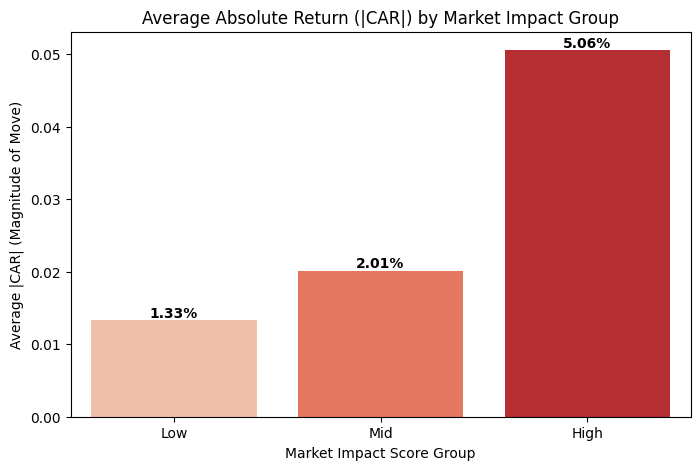

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# ==============================================================================
# 1. CAR 데이터 재집계 (Ticker, Time 포함하여 다시 생성)
# ==============================================================================
print("--- CAR 및 메타데이터 재집계 중... ---")
results = []

# tweet_df와 adj_close_data, calculate_car 함수가 메모리에 있다고 가정합니다.
for idx, row in tweet_df.iterrows():
    car = calculate_car(row['ticker'], row['time'], row['market_ticker'], adj_close_data)

    results.append({
        'ticker': row['ticker'],       # ★ 중요: Merge를 위해 추가
        'time': row['time'],           # ★ 중요: Merge를 위해 추가
        'sentiment': row['sentiment_score'],
        'market_impact': row['market_impact_score'],
        'CAR': car
    })

# 결측치 제거된 분석용 데이터프레임 생성
analysis_df = pd.DataFrame(results).dropna()
print(f"-> 데이터 집계 완료. (유효 샘플: {len(analysis_df)}개)")

# ==============================================================================
# 2. 원본 텍스트(Content) 병합
# ==============================================================================
# full_tweet_df에서 텍스트 정보 가져오기
if 'content' in full_tweet_df.columns:
    # 병합을 위해 필요한 컬럼만 추출
    content_df = full_tweet_df[['ticker', 'time', 'content']].copy()
    content_df['time'] = pd.to_datetime(content_df['time'])
    analysis_df['time'] = pd.to_datetime(analysis_df['time'])

    # ticker와 time 기준으로 병합
    verify_df = pd.merge(analysis_df, content_df, on=['ticker', 'time'], how='left')
    print("-> 텍스트 데이터 병합 성공")
else:
    print("주의: 'content' 컬럼이 없어 텍스트 검증은 건너뜁니다.")
    verify_df = analysis_df.copy()
    verify_df['content'] = "[내용 없음]"

# ==============================================================================
# 3. [검증 1] 정성적 분석 (High vs Low Score 실제 트윗 비교)
# ==============================================================================
print("\n========== [검증 1] Market Impact Score 상/하위 트윗 내용 비교 ==========")

# 상위 5개 (Impact가 크다고 예측한 것)
top_5 = verify_df.sort_values(by='market_impact', ascending=False).head(5)
print("\n>>> Top 5 High Impact Tweets (GPT가 '중요하다'고 판단):")
for i, row in top_5.iterrows():
    text_preview = row['content'][:100] + "..." if isinstance(row['content'], str) else "내용 없음"
    print(f"[{row['ticker']}] Score: {row['market_impact']:.2f} | CAR: {row['CAR']:.2%} | {text_preview}")

# 하위 5개 (Impact가 작다고 예측한 것)
bottom_5 = verify_df.sort_values(by='market_impact', ascending=True).head(5)
print("\n>>> Bottom 5 Low Impact Tweets (GPT가 '별거 아니다'라고 판단):")
for i, row in bottom_5.iterrows():
    text_preview = row['content'][:100] + "..." if isinstance(row['content'], str) else "내용 없음"
    print(f"[{row['ticker']}] Score: {row['market_impact']:.2f} | CAR: {row['CAR']:.2%} | {text_preview}")

# ==============================================================================
# 4. [검증 2] 변동성(Magnitude) 상관관계 분석
# ==============================================================================
print("\n========== [검증 2] 변동성(주가 움직임의 크기)과의 상관관계 ==========")

# 절대 수익률(변동성) 계산
verify_df['abs_CAR'] = verify_df['CAR'].abs()

# 단순 상관계수 출력
corr_impact_abs = verify_df['market_impact'].corr(verify_df['abs_CAR'])
corr_sent_abs = verify_df['sentiment'].corr(verify_df['abs_CAR'])

print(f"Market Impact Score vs 절대수익률(|CAR|) 상관계수: {corr_impact_abs:.4f}")
print(f"Sentiment Score     vs 절대수익률(|CAR|) 상관계수: {corr_sent_abs:.4f}")

if abs(corr_impact_abs) > abs(corr_sent_abs):
    print("-> 결론: Market Impact Score가 주가의 '변동폭(크기)'을 더 잘 설명합니다.")
else:
    print("-> 결론: Sentiment Score가 변동폭 설명력이 더 높습니다.")

# ==============================================================================
# 5. [검증 3] 구간별(Tier) 수익률 차이 분석
# ==============================================================================
print("\n========== [검증 3] 점수 구간별 평균 변동성 비교 ==========")

# 3개 구간으로 나누기 (Low, Mid, High)
verify_df['impact_group'] = pd.qcut(verify_df['market_impact'], 3, labels=['Low', 'Mid', 'High'])

# 그룹별 평균 절대 수익률 계산
group_stats = verify_df.groupby('impact_group')['abs_CAR'].mean()

print("그룹별 평균 절대 수익률(|CAR|):")
print(group_stats)

# 시각화
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=group_stats.index, y=group_stats.values, palette='Reds')
plt.title('Average Absolute Return (|CAR|) by Market Impact Group')
plt.ylabel('Average |CAR| (Magnitude of Move)')
plt.xlabel('Market Impact Score Group')

# 막대 위에 수치 표시
for i, v in enumerate(group_stats.values):
    plt.text(i, v, f"{v:.2%}", ha='center', va='bottom', fontweight='bold')

plt.show()

###3. 회귀분석1_단일변수, 다중회귀

--- 데이터 로드 중... ---
-> 데이터 로드 완료: 291건
  ticker                time  sentiment_score  market_impact_score  \
0   KVUE 2025-10-26 16:19:00             -0.7                  0.6   
1    MRK 2025-10-26 16:19:00             -0.7                  0.6   
2    GSK 2025-10-26 16:19:00             -0.7                  0.6   
3    JNJ 2025-10-26 16:19:00             -0.7                  0.6   
4    PFE 2025-10-26 16:19:00             -0.7                  0.6   

  market_ticker  
0         ^GSPC  
1         ^GSPC  
2         ^GSPC  
3         ^GSPC  
4         ^GSPC  

--- 주가 데이터 다운로드 및 CAR(0,0) 계산 ---


/tmp/ipython-input-3816714471.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start=start_date.date(), progress=False)


-> 주가 데이터 다운로드 완료
-> CAR 계산 완료 (유효 샘플: 233개)

[회귀분석 결과 비교]
Variable        | R-squared  | P-value    | Coef      
-------------------------------------------------------
Sentiment       | 0.0169     | 0.0475     | 0.0108
Market Impact   | 0.0385     | 0.0026     | 0.0499
-------------------------------------------------------
[다중회귀분석 결과 (Sentiment + Market Impact)]
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     5.300
Date:                Mon, 01 Dec 2025   Prob (F-statistic):            0.00562
Time:                        13:53:26   Log-Likelihood:                 347.12
No. Observations:                 233   AIC:                            -688.2
Df Residuals:                     230   BIC:                            -677.9


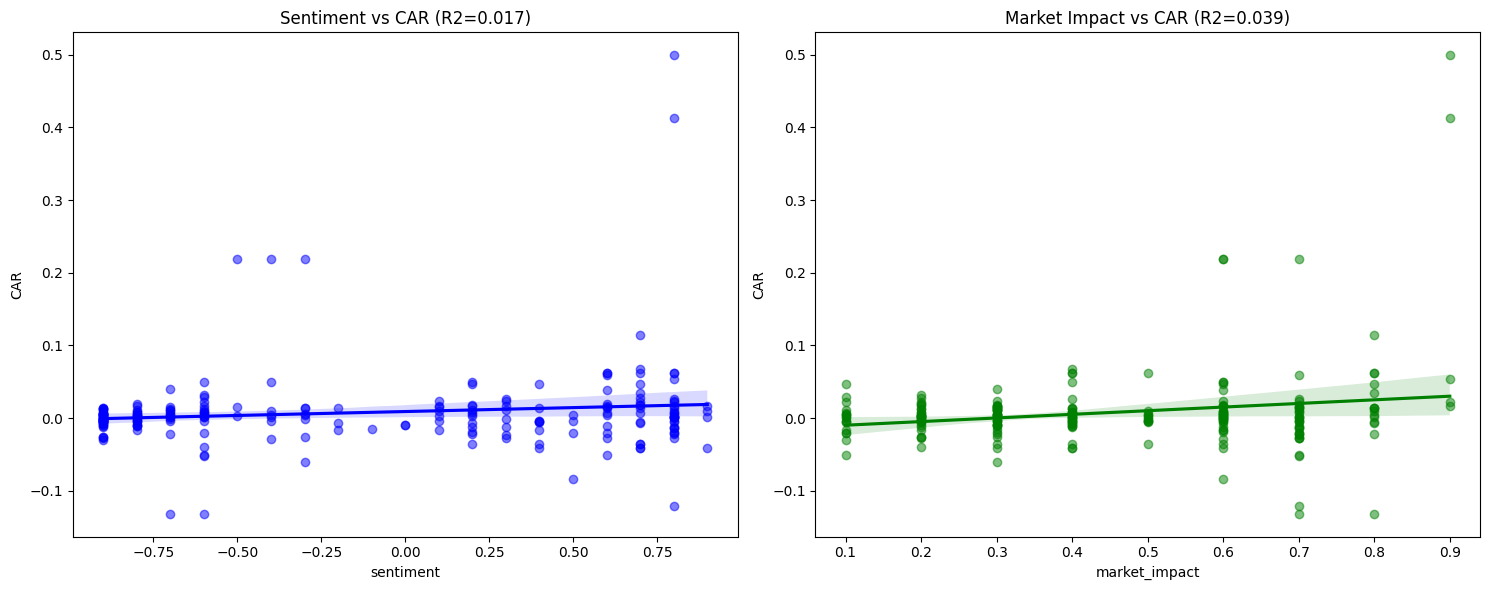

In [ ]:
# ==============================================================================
# 1. 라이브러리 임포트 및 설정
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# ==============================================================================
# 2. 데이터 로드
# ==============================================================================
print("--- 데이터 로드 중... ---")
try:
    # 데이터 파일 로드
    full_tweet_df = pd.read_csv('Direct_data_all_by_ticker_F.csv')

    # 필요한 컬럼만 선택 (market_impact_score 포함)
    tweet_df = full_tweet_df[['ticker', 'time', 'sentiment_score', 'market_impact_score']].copy()
    tweet_df['market_ticker'] = '^GSPC' # S&P 500 지수
    tweet_df['time'] = pd.to_datetime(tweet_df['time'])

    print(f"-> 데이터 로드 완료: {len(tweet_df)}건")
    print(tweet_df.head())

except FileNotFoundError:
    print("오류: 'Direct_data_all_by_ticker_F.csv' 파일을 찾을 수 없습니다.")
    raise

# ==============================================================================
# 3. 주가 데이터 다운로드 및 CAR(0,0) 계산
# ==============================================================================
print("\n--- 주가 데이터 다운로드 및 CAR(0,0) 계산 ---")
MARKET_CLOSE_HOUR = 16
ESTIMATION_PERIOD_DAYS = 251
EVENT_WINDOW_DAYS = 0  # 하루 모델

# 티커 리스트
all_tickers = list(set(tweet_df['ticker'].unique().tolist() + tweet_df['market_ticker'].unique().tolist()))
start_date = tweet_df['time'].min().normalize() - timedelta(days=ESTIMATION_PERIOD_DAYS * 1.5)

# 다운로드
try:
    all_data = yf.download(all_tickers, start=start_date.date(), progress=False)
    if 'Adj Close' in all_data.columns.get_level_values(0):
        adj_close_data = all_data['Adj Close'].dropna(how='all')
    else:
        adj_close_data = all_data['Close'].dropna(how='all')
    print("-> 주가 데이터 다운로드 완료")
except Exception as e:
    print(f"-> 주가 다운로드 오류: {e}")
    raise

# CAR 계산 함수
def calculate_car(ticker, time, market_ticker, adj_close_data):
    if time.hour >= MARKET_CLOSE_HOUR:
        t0 = (time + timedelta(days=1)).normalize()
    else:
        t0 = time.normalize()

    est_end = t0 - timedelta(days=1)
    est_start = est_end - timedelta(days=380)
    event_end = t0 + timedelta(days=EVENT_WINDOW_DAYS)

    try:
        returns = adj_close_data[[ticker, market_ticker]].pct_change(fill_method=None).dropna()
    except KeyError:
        return np.nan

    if returns.empty: return np.nan

    # 추정 기간
    est_returns = returns[ticker].loc[est_start:est_end].iloc[-ESTIMATION_PERIOD_DAYS:]
    est_market = returns[market_ticker].loc[est_returns.index]

    if len(est_returns) < 200: return np.nan

    # 시장 모형
    model = sm.OLS(est_returns, sm.add_constant(est_market), missing='drop').fit()
    alpha, beta = model.params.get('const', 0), model.params.get(market_ticker, 1)

    # 이벤트 윈도우
    event_stock = returns[ticker].loc[t0:event_end]
    event_market = returns[market_ticker].loc[t0:event_end]

    if event_stock.empty: return np.nan

    abnormal_returns = event_stock - (alpha + beta * event_market)
    return abnormal_returns.sum()

# 루프 실행
results = []
for idx, row in tweet_df.iterrows():
    car = calculate_car(row['ticker'], row['time'], row['market_ticker'], adj_close_data)
    results.append({
        'sentiment': row['sentiment_score'],
        'market_impact': row['market_impact_score'],
        'CAR': car
    })

analysis_df = pd.DataFrame(results).dropna()
print(f"-> CAR 계산 완료 (유효 샘플: {len(analysis_df)}개)")

# ==============================================================================
# 4. 회귀분석 비교: Sentiment vs Market Impact
# ==============================================================================
print("\n[회귀분석 결과 비교]")
print(f"{'Variable':<15} | {'R-squared':<10} | {'P-value':<10} | {'Coef':<10}")
print("-" * 55)

# 1) Sentiment Score
X1 = sm.add_constant(analysis_df['sentiment'])
model1 = sm.OLS(analysis_df['CAR'], X1).fit()
print(f"{'Sentiment':<15} | {model1.rsquared:.4f}     | {model1.pvalues['sentiment']:.4f}     | {model1.params['sentiment']:.4f}")

# 2) Market Impact Score
X2 = sm.add_constant(analysis_df['market_impact'])
model2 = sm.OLS(analysis_df['CAR'], X2).fit()
print(f"{'Market Impact':<15} | {model2.rsquared:.4f}     | {model2.pvalues['market_impact']:.4f}     | {model2.params['market_impact']:.4f}")

# 3) (선택) 두 변수 동시 투입 (다중회귀)
X3 = sm.add_constant(analysis_df[['sentiment', 'market_impact']])
model3 = sm.OLS(analysis_df['CAR'], X3).fit()
print("-" * 55)
print("[다중회귀분석 결과 (Sentiment + Market Impact)]")
print(model3.summary())

# 시각화 (산점도 및 회귀선)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sentiment
sns.regplot(x='sentiment', y='CAR', data=analysis_df, ax=axes[0], color='blue', scatter_kws={'alpha':0.5})
axes[0].set_title(f'Sentiment vs CAR (R2={model1.rsquared:.3f})')

# Market Impact
sns.regplot(x='market_impact', y='CAR', data=analysis_df, ax=axes[1], color='green', scatter_kws={'alpha':0.5})
axes[1].set_title(f'Market Impact vs CAR (R2={model2.rsquared:.3f})')

plt.tight_layout()
plt.show()

###4. 회귀분석(2)_상호작용 회귀모형

--- [심화 분석] 변수 간 관계 및 상호작용 검증 ---

1. 상관계수 행렬:
               sentiment  market_impact
sentiment       1.000000       0.250262
market_impact   0.250262       1.000000

2. 다중공선성 지수(VIF):
         feature       VIF
0          const  5.572066
1      sentiment  1.066816
2  market_impact  1.066816

3. 상호작용 모델(Interaction Model) 결과:
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.722
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000847
Time:                        13:35:29   Log-Likelihood:                 373.61
No. Observations:                 245   AIC:                            -739.2
Df Residuals:                     241   BIC:                            -725.2
Df Model:                           3  

<Figure size 1000x600 with 0 Axes>

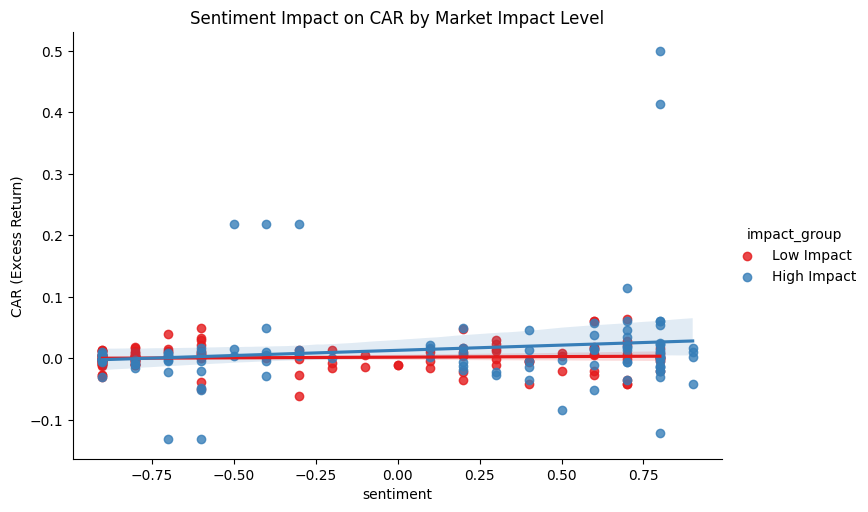

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# (이전 단계의 analysis_df가 메모리에 있다고 가정합니다)
# analysis_df = ...

print("--- [심화 분석] 변수 간 관계 및 상호작용 검증 ---")

# 1. 두 변수 간 상관관계 확인
# 상관계수가 0.4~0.5 이상이면 둘은 비슷한 정보를 담고 있다는 뜻입니다.
corr = analysis_df[['sentiment', 'market_impact']].corr()
print("\n1. 상관계수 행렬:")
print(corr)

# 2. 다중공선성(VIF) 확인
# VIF가 5~10을 넘어가면 OLS에서 둘을 같이 쓰기 어렵습니다.
X = sm.add_constant(analysis_df[['sentiment', 'market_impact']])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n2. 다중공선성 지수(VIF):")
print(vif_data)

# 3. 상호작용 항(Interaction Term) 추가 회귀분석
# 전략: Sentiment와 Market Impact를 곱한 새로운 변수를 만듭니다.
# 의미: "단순히 긍정적인 것보다, '파급력이 큰 긍정'일 때 주가가 더 오르는가?"
analysis_df['interaction'] = analysis_df['sentiment'] * analysis_df['market_impact']

X_inter = sm.add_constant(analysis_df[['sentiment', 'market_impact', 'interaction']])
y = analysis_df['CAR']

model_inter = sm.OLS(y, X_inter).fit()

print("\n3. 상호작용 모델(Interaction Model) 결과:")
print(model_inter.summary())

# ------------------------------------------------------------------
# [시각화] 상호작용 효과 눈으로 확인하기
# Market Impact를 High/Low로 나누어 Sentiment의 기울기 변화 관찰
# ------------------------------------------------------------------
analysis_df['impact_group'] = pd.qcut(analysis_df['market_impact'], 2, labels=['Low Impact', 'High Impact'])

plt.figure(figsize=(10, 6))
sns.lmplot(x='sentiment', y='CAR', hue='impact_group', data=analysis_df, aspect=1.5, palette='Set1')
plt.title('Sentiment Impact on CAR by Market Impact Level')
plt.ylabel('CAR (Excess Return)')
plt.show()

5. 회귀분석(3)_상호작용+시가총액변수 추가 회귀모형

###5. 회귀분석(3)_상호작용+시가총액변수 추가 회귀모형(수정)

--- [High-Precision Analysis] AR(수정주가) & Mcap(미수정주가) 이중 적용 ---
-> 데이터 로드 완료: 291건

--- 데이터 수집 시작 (정밀 계산을 위해 주가 데이터를 이중으로 받습니다) ---
1. 수익률 분석용 수정 주가(Adjusted Price) 다운로드 중...
   -> 수정 주가 다운로드 완료
2. 시가총액 계산용 미수정 주가(Unadjusted Price) 다운로드 중...
   -> 미수정 주가 다운로드 완료
3. 종목별 주식 수 변동 내역(Shares History) 수집 중 (53개 종목)...
   ... 10/53 완료
   ... 20/53 완료
   ... 30/53 완료
   ... 40/53 완료
   ... 50/53 완료
   -> 주식 수 데이터 수집 완료

--- 이벤트별 정밀 분석 실행 ---
... 0/291 완료
... 50/291 완료
... 100/291 완료
... 150/291 완료
... 200/291 완료
... 250/291 완료
-> 최종 유효 샘플 수: 291개

 [High-Precision Result: AR(Decimal) ~ Factors]
 * AR 단위: Decimal (0.01 = 1%)
 * Mcap 계산: Unadjusted Price * Historical Shares
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     11.81
Date:       

/usr/local/lib/python3.12/dist-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1000x600 with 0 Axes>

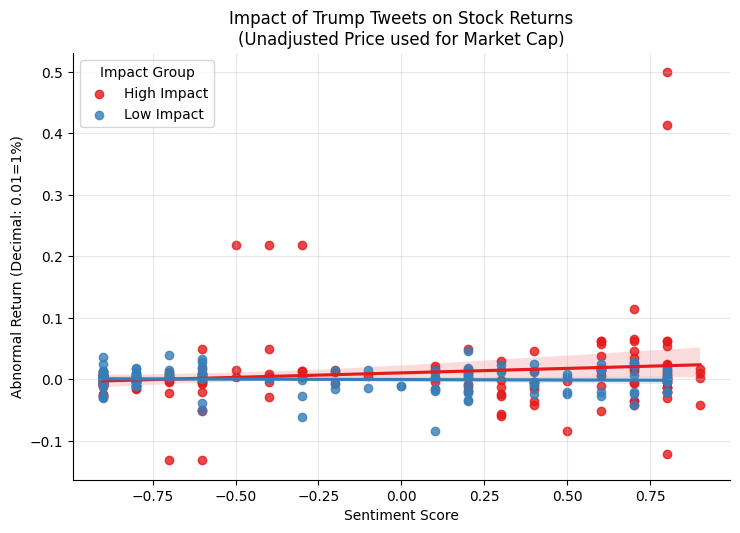

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

print("--- [High-Precision Analysis] AR(수정주가) & Mcap(미수정주가) 이중 적용 ---")

# ==============================================================================
# 1. 데이터 로드 및 전처리
# ==============================================================================
try:
    # 파일 로드
    tweet_df = pd.read_csv('Direct_data_all_by_ticker_F.csv')

    # 컬럼 선택 및 전처리
    tweet_df = tweet_df[['ticker', 'time', 'sentiment_score', 'market_impact_score']].copy()
    tweet_df['market_ticker'] = '^GSPC' # S&P 500
    tweet_df['time'] = pd.to_datetime(tweet_df['time'])

    # 타임존 제거
    if tweet_df['time'].dt.tz is not None:
        tweet_df['time'] = tweet_df['time'].dt.tz_localize(None)

    print(f"-> 데이터 로드 완료: {len(tweet_df)}건")

except Exception as e:
    print(f"데이터 로드 오류: {e}")
    raise

# ==============================================================================
# 2. 데이터 수집 (Dual Price Data & Shares)
# ==============================================================================
print("\n--- 데이터 수집 시작 (정밀 계산을 위해 주가 데이터를 이중으로 받습니다) ---")

MARKET_CLOSE_HOUR = 16
unique_tickers = tweet_df['ticker'].unique().tolist()
market_ticker = '^GSPC'
all_tickers = list(set(unique_tickers + [market_ticker]))

start_date = tweet_df['time'].min() - timedelta(days=400)
end_date = tweet_df['time'].max() + timedelta(days=10)

# 2-1. [수익률 계산용] 수정 주가 (Adjusted Close) 다운로드
# 배당, 액면분할이 반영된 가격 -> 수익률(Return) 계산에 사용
print("1. 수익률 분석용 수정 주가(Adjusted Price) 다운로드 중...")
try:
    prices_adj = yf.download(all_tickers, start=start_date, end=end_date,
                             progress=False, group_by='ticker', auto_adjust=True)
    print("   -> 수정 주가 다운로드 완료")
except Exception as e:
    print(f"   -> 다운로드 실패: {e}")
    raise

# 2-2. [시가총액 계산용] 미수정 주가 (Unadjusted Close) 다운로드
# 액면분할 등이 반영 안 된 가격 -> 과거 주식 수와 곱해서 시가총액 구할 때 사용
print("2. 시가총액 계산용 미수정 주가(Unadjusted Price) 다운로드 중...")
try:
    prices_raw = yf.download(all_tickers, start=start_date, end=end_date,
                             progress=False, group_by='ticker', auto_adjust=False)
    print("   -> 미수정 주가 다운로드 완료")
except Exception as e:
    print(f"   -> 다운로드 실패: {e}")
    raise

# 2-3. 종목별 과거 주식 수(Historical Shares) 수집
shares_history_dict = {}
print(f"3. 종목별 주식 수 변동 내역(Shares History) 수집 중 ({len(unique_tickers)}개 종목)...")

for i, t in enumerate(unique_tickers):
    try:
        ticker_obj = yf.Ticker(t)
        full_shares = ticker_obj.get_shares_full(start=start_date)

        if full_shares.index.tz is not None:
            full_shares.index = full_shares.index.tz_localize(None)

        shares_history_dict[t] = full_shares

    except Exception:
        shares_history_dict[t] = None

    if (i + 1) % 10 == 0:
        print(f"   ... {i + 1}/{len(unique_tickers)} 완료")

print("   -> 주식 수 데이터 수집 완료")

# ==============================================================================
# 3. 개별 이벤트 분석 함수 (Logic 분리 적용)
# ==============================================================================
def analyze_event_precise(row, prices_adj, prices_raw, shares_dict):
    ticker = row['ticker']
    event_time = row['time']
    mkt_ticker = row['market_ticker']

    # 1. 이벤트 기준일(t0) 설정
    if event_time.hour >= MARKET_CLOSE_HOUR:
        t0 = event_time + timedelta(days=1)
    else:
        t0 = event_time

    try:
        # ------------------------------------------------------------------
        # A. 수익률(AR) 계산 -> prices_adj (수정 주가) 사용
        # ------------------------------------------------------------------
        try:
            # yfinance MultiIndex 처리 (단일 종목일 경우와 다수 종목일 경우 구조 차이 대응)
            if isinstance(prices_adj.columns, pd.MultiIndex):
                price_series_adj = prices_adj[ticker]['Close'].dropna()
                mkt_series_adj = prices_adj[mkt_ticker]['Close'].dropna()
            else: # 단일 종목 다운로드 시 구조가 다를 수 있음 (예외처리)
                price_series_adj = prices_adj['Close'].dropna()
                # 시장 데이터는 별도로 필요할 수 있으나 여기선 생략 또는 구조에 맞게 처리
                return None
        except KeyError:
            return None

        # 타임존 제거
        price_series_adj.index = price_series_adj.index.tz_localize(None)
        mkt_series_adj.index = mkt_series_adj.index.tz_localize(None)

        # 실제 거래일 찾기
        valid_dates = price_series_adj.index
        t0_loc = valid_dates[valid_dates >= t0.normalize()]
        if len(t0_loc) == 0: return None
        real_t0 = t0_loc[0]

        # Estimation Window: t-252 ~ t-1
        est_end_date = real_t0 - timedelta(days=1)
        est_start_date = est_end_date - timedelta(days=365)

        stock_ret = price_series_adj.pct_change().dropna()
        mkt_ret = mkt_series_adj.pct_change().dropna()
        df_ret = pd.DataFrame({'stock': stock_ret, 'market': mkt_ret}).dropna()

        # 시장모형(Beta) 학습
        est_data = df_ret.loc[est_start_date : est_end_date]
        if len(est_data) < 60: return None

        X = sm.add_constant(est_data['market'])
        model = sm.OLS(est_data['stock'], X).fit()
        alpha, beta = model.params['const'], model.params['market']

        # AR 계산 (Day 0) - Decimal 단위 (0.01 = 1%)
        if real_t0 not in df_ret.index: return None
        actual_ret = df_ret.loc[real_t0, 'stock']
        mkt_ret_day = df_ret.loc[real_t0, 'market']
        expected_ret = alpha + (beta * mkt_ret_day)
        ar = actual_ret - expected_ret

        # ------------------------------------------------------------------
        # B. 시가총액(Mcap) 계산 -> prices_raw (미수정 주가) + Shares History
        # ------------------------------------------------------------------
        # t-1 시점 찾기
        last_price_date = est_data.index[-1]

        # 미수정 주가 가져오기 (Raw Price)
        if isinstance(prices_raw.columns, pd.MultiIndex):
            price_series_raw = prices_raw[ticker]['Close']
        else:
            price_series_raw = prices_raw['Close']

        # 인덱스 타임존 정리
        if price_series_raw.index.tz is not None:
            price_series_raw.index = price_series_raw.index.tz_localize(None)

        try:
            raw_price_t_minus_1 = price_series_raw.loc[last_price_date]
        except KeyError:
            # 조정 주가 날짜와 미조정 주가 날짜가 미세하게 다를 경우 가장 가까운 전날 찾기
            raw_price_t_minus_1 = price_series_raw.asof(last_price_date)

        if pd.isna(raw_price_t_minus_1): return None

        # t-1 시점의 주식 수 찾기
        hist_shares = shares_dict.get(ticker)
        if hist_shares is not None and not hist_shares.empty:
            shares_at_time = hist_shares.asof(last_price_date)
            if pd.isna(shares_at_time): shares_at_time = hist_shares.iloc[0]
        else:
            return None

        # [핵심] 시가총액 = 미수정 주가 * 당시 주식 수
        mcap = raw_price_t_minus_1 * shares_at_time

        return {
            'ticker': ticker,
            'time': event_time,
            'target_date': real_t0,
            'sentiment': row['sentiment_score'],
            'market_impact': row['market_impact_score'],
            'CAR': ar,    # Decimal AR
            'mcap': mcap  # Precise Mcap
        }

    except Exception:
        return None

# ==============================================================================
# 4. 루프 실행 및 분석
# ==============================================================================
results = []
print("\n--- 이벤트별 정밀 분석 실행 ---")

for idx, row in tweet_df.iterrows():
    # 수정된 함수 호출 (인자: prices_adj, prices_raw 둘 다 전달)
    res = analyze_event_precise(row, prices_adj, prices_raw, shares_history_dict)
    if res:
        results.append(res)

    if idx % 50 == 0:
        print(f"... {idx}/{len(tweet_df)} 완료")

analysis_df = pd.DataFrame(results)
print(f"-> 최종 유효 샘플 수: {len(analysis_df)}개")

# ==============================================================================
# 5. 최종 회귀분석 및 시각화
# ==============================================================================
if not analysis_df.empty:
    # 로그 변환 (Skewness 완화)
    analysis_df['log_mcap'] = np.log(analysis_df['mcap'])
    analysis_df['interaction'] = analysis_df['sentiment'] * analysis_df['market_impact']

    print("\n" + "="*60)
    print(" [High-Precision Result: AR(Decimal) ~ Factors]")
    print(" * AR 단위: Decimal (0.01 = 1%)")
    print(" * Mcap 계산: Unadjusted Price * Historical Shares")
    print("="*60)

    # OLS 회귀분석
    X = analysis_df[['sentiment', 'market_impact', 'interaction', 'log_mcap']]
    X = sm.add_constant(X)
    y = analysis_df['CAR'] # 순수 Decimal 유지

    model_final = sm.OLS(y, X).fit()
    print(model_final.summary())

    # 시각화 (단위: Decimal)
    plt.figure(figsize=(10, 6))
    median_impact = analysis_df['market_impact'].median()
    analysis_df['Impact Group'] = np.where(analysis_df['market_impact'] >= median_impact, 'High Impact', 'Low Impact')

    sns.lmplot(x='sentiment', y='CAR', hue='Impact Group', data=analysis_df,
               aspect=1.5, palette='Set1', legend_out=False)
    plt.title('Impact of Trump Tweets on Stock Returns\n(Unadjusted Price used for Market Cap)', fontsize=12)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Abnormal Return (Decimal: 0.01=1%)')
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("분석할 데이터가 없습니다.")

###예측 초과수익률과 실제 초과수익률 비교(테스트용)

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import timedelta

# ==============================================================================
# 1. 정밀 시가총액 계산 함수 (Helper Function)
#    [핵심] 시가총액 계산에는 '미수정 주가'를 사용해야 합니다.
# ==============================================================================
def get_precise_log_mcap(ticker_symbol, target_date):
    """과거 특정 시점의 주식 수와 '미수정 주가'를 찾아 Log Mcap 계산"""
    try:
        ticker = yf.Ticker(ticker_symbol)

        # [수정 포인트] auto_adjust=False 설정 (미수정 주가 확보)
        # 액면분할 등이 반영되지 않은 '당시의 그 가격'을 가져옵니다.
        hist = ticker.history(start=target_date - timedelta(days=10),
                              end=target_date,
                              auto_adjust=False)

        if hist.empty: return None, "주가 데이터 없음"
        hist.index = hist.index.tz_localize(None)

        past_data = hist[hist.index < target_date]
        if past_data.empty: return None, "이전 거래일 데이터 없음"

        # 미수정 종가 추출
        price_t_minus_1 = past_data['Close'].iloc[-1]
        date_t_minus_1 = past_data.index[-1]

        # 과거 주식 수 (Shares)
        try:
            shares_history = ticker.get_shares_full(start=target_date - timedelta(days=365*5))
            if shares_history.index.tz is not None:
                shares_history.index = shares_history.index.tz_localize(None)

            shares_at_time = shares_history.asof(date_t_minus_1)
            if pd.isna(shares_at_time): shares_at_time = shares_history.iloc[0]

        except:
            # API 실패 시 차선책
            try: shares_at_time = ticker.fast_info['shares']
            except: shares_at_time = ticker.info.get('sharesOutstanding')

        if not shares_at_time: return None, "주식 수 정보 없음"

        # [계산] 미수정 주가 * 당시 주식 수 = 정확한 시가총액
        mcap = price_t_minus_1 * shares_at_time
        log_mcap = np.log(mcap)

        return log_mcap, f"${mcap/1e9:.2f}B"

    except Exception as e:
        return None, f"Error: {e}"

# ==============================================================================
# 2. 개별 종목 분석 로직 (Decimal 기준)
#    [핵심] 수익률(AR) 계산에는 '수정 주가'를 사용해야 합니다.
# ==============================================================================
def analyze_single_ticker(ticker, event_date, sentiment, impact):
    # 1. 시가총액 계산 (위에서 정의한 정밀 함수 호출)
    log_mcap, mcap_info = get_precise_log_mcap(ticker, event_date)
    if log_mcap is None: return None

    # 2. 모델 예측 (Decimal 계수 적용)
    # y = 0.1869... 식은 결과가 Decimal로 나온다고 가정
    interaction = sentiment * impact
    predicted_ar = (0.1869
                    - 0.0109 * sentiment
                    + 0.0490 * impact
                    + 0.0522 * interaction
                    - 0.0080 * log_mcap)

    # 3. 실측값 검증 (Market Model)
    start_date = event_date - timedelta(days=400)
    end_date = event_date + timedelta(days=10)

    try:
        # [수정 포인트] auto_adjust=True (수익률 계산용 수정 주가 다운로드)
        data = yf.download([ticker, '^GSPC'], start=start_date, end=end_date,
                           progress=False, group_by='ticker', auto_adjust=True)
    except: return None

    # 데이터 정리
    try:
        stock_close = data[ticker]['Close'].dropna()
        market_close = data['^GSPC']['Close'].dropna()
    except KeyError: # yfinance 구조 대응
        stock_close = data.xs(ticker, axis=1, level=0)['Close'].dropna()
        market_close = data.xs('^GSPC', axis=1, level=0)['Close'].dropna()

    stock_close.index = stock_close.index.tz_localize(None)
    market_close.index = market_close.index.tz_localize(None)

    # pct_change() -> 이미 Decimal (0.01 = 1%)
    df = pd.DataFrame({'stock': stock_close.pct_change(), 'market': market_close.pct_change()}).dropna()

    if event_date not in df.index:
        valid_dates = df.index[df.index >= event_date]
        if len(valid_dates) == 0: return None
        target_date = valid_dates[0]
    else:
        target_date = event_date

    # 베타 추정 및 AR 계산
    est_end = target_date - timedelta(days=1)
    est_start = est_end - timedelta(days=365)
    est_data = df.loc[est_start : est_end]

    if len(est_data) < 60:
        # [수정] * 100 제거 (Decimal 유지)
        actual_ar = df.loc[target_date, 'stock'] - df.loc[target_date, 'market']
    else:
        X = sm.add_constant(est_data['market'])
        model = sm.OLS(est_data['stock'], X).fit()
        alpha, beta = model.params['const'], model.params['market']

        real_ret = df.loc[target_date, 'stock']
        mkt_ret = df.loc[target_date, 'market']
        expected_ret = alpha + (beta * mkt_ret)

        # [수정] * 100 제거 (Decimal 유지)
        actual_ar = real_ret - expected_ret

    return {
        'ticker': ticker,
        'mcap_info': mcap_info,
        'predicted': predicted_ar,
        'actual': actual_ar,
        'error': actual_ar - predicted_ar,
        'date_used': target_date.strftime('%Y-%m-%d')
    }

# ==============================================================================
# 3. 다중 종목 실행 함수 (Decimal Reporting)
# ==============================================================================
def run_multi_analysis(ticker_list, date_str, sentiment, impact):
    print(f"\n[다중 기업 분석] 트윗 날짜: {date_str}")
    print(f"   조건: Sentiment({sentiment}) / Impact({impact})")
    print("=" * 75)

    event_date = pd.to_datetime(date_str)
    results = []

    # 리스트 내 종목 순차 분석
    for t in ticker_list:
        print(f"분석 중: {t}...", end=" ")
        try:
            res = analyze_single_ticker(t, event_date, sentiment, impact)
            if res:
                print(f"완료")
                results.append(res)
            else:
                print("실패 (데이터 부족)")
        except Exception as e:
            print(f"에러 ({e})")

    # 종합 결과 출력
    if results:
        df_res = pd.DataFrame(results)

        print("\n [최종 비교 리포트 (단위: Decimal)]")
        print("   * 0.0100 = 1% 상승")
        print("-" * 75)

        display_df = df_res[['ticker', 'mcap_info', 'predicted', 'actual', 'error']].copy()
        display_df.columns = ['종목', '당시 시가총액', '예측 AR', '실제 AR', '오차(Diff)']
        display_df = display_df.set_index('종목')

        # 소수점 4자리까지 출력 (1bp 단위 확인)
        print(display_df.round(4))
        print("-" * 75)

        avg_error = df_res['error'].mean()
        print(f" 평균 오차: {avg_error:.4f} ({avg_error*100:.2f}%p)")

        if avg_error > 0:
            print("   -> (Actual > Predicted) 실제 수익률이 예측보다 높음")
        else:
            print("   -> (Actual < Predicted) 실제 수익률이 예측보다 낮음")
    else:
        print("분석된 결과가 없습니다.")
    print("=" * 75)

# ==========================================
# 실행부
# ==========================================
# 날짜 입력 규칙 (Date Input Rule) : 미국 현지 시각 기준
# 예: 12월 9일 장중/장전 -> "2025-12-09"
# 예: 12월 9일 장후 -> "2025-12-10"

target_tickers = ["NVDA", "AMD", "INTC"]
tweet_date = "2025-12-09" # 테스트 날짜 (미래 날짜면 에러날 수 있으니 과거/현재로 설정)
my_impact = 0.7
my_sent = 0.5

run_multi_analysis(target_tickers, tweet_date, my_sent, my_impact)


[다중 기업 분석] 트윗 날짜: 2025-12-09
   조건: Sentiment(0.5) / Impact(0.7)
분석 중: NVDA... 완료
분석 중: AMD... 완료
분석 중: INTC... 완료

 [최종 비교 리포트 (단위: Decimal)]
   * 0.0100 = 1% 상승
---------------------------------------------------------------------------
        당시 시가총액   예측 AR   실제 AR  오차(Diff)
종목                                       
NVDA  $4517.59B  0.0009 -0.0020   -0.0029
AMD    $359.98B  0.0211  0.0027   -0.0185
INTC   $192.23B  0.0262  0.0038   -0.0224
---------------------------------------------------------------------------
 평균 오차: -0.0146 (-1.46%p)
   -> (Actual < Predicted) 실제 수익률이 예측보다 낮음
